# 流变性能预测 - 基于广义Maxwell模型的曲线级别学习

In [13]:
# 导入所需的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子以确保可重复性
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print("✅ 环境配置完成")

使用设备: cpu
✅ 环境配置完成


In [ ]:
# ============================================================================
# 数据集类：曲线级别组织
# ============================================================================

class RheologyCurveDataset:
    """
    将数据组织成曲线级别，每个样本是一条完整的频率扫描曲线
    """
    
    def __init__(self, csv_path: str):
        self.df = pd.read_csv(csv_path)
        self.process_data()
        
    def process_data(self):
        """处理数据并组织成曲线格式"""
        df = self.df
        
        # 过滤异常值
        df['tan_delta'] = df['G2_Pa'] / df['G1_Pa']
        df = df[(df['tan_delta'] >= 0) & (df['tan_delta'] <= 10)].copy()
        
        # 特征工程（样本级别，不包括频率）
        df['aspect_ratio'] = df['Length_nm'] / df['Width_nm']
        df['log_Mw'] = np.log10(df['Mw'])
        df['log_Mn'] = np.log10(df['Mn'])
        df['PDI'] = df['Mw'] / df['Mn']
        df['log_c'] = np.log10(df['c'])
        
        # WLF时温等效
        T_ref = 25
        C1 = 8.86
        C2 = 101.6
        df['aT'] = 10 ** (-C1 * (df['Temp_C'] - T_ref) / (C2 + df['Temp_C'] - T_ref))
        df['temp_inv'] = 1 / (df['Temp_C'] + 273.15)
        df['T_x_aspect'] = df['Temp_C'] * df['aspect_ratio']
        
        # 对数转换
        df['log_G1'] = np.log10(np.clip(df['G1_Pa'], 1e-10, None))
        df['log_G2'] = np.log10(np.clip(df['G2_Pa'], 1e-10, None))
        df['log_freq'] = np.log10(df['Freq_rad_s'])
        
        # 样本级别特征（不包括频率相关的）
        self.sample_feature_cols = [
            'Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C',
            'temp_inv', 'T_x_aspect', 'aT',
            'log_Mw', 'log_Mn', 'PDI', 'log_c'
        ]
        
        # 按样本ID分组
        self.samples = []
        self.sample_ids = []
        
        for sample_id in df['Sample_ID'].unique():
            sample_df = df[df['Sample_ID'] == sample_id].sort_values('Freq_rad_s')
            
            # 确保有足够的数据点
            if len(sample_df) < 10:
                continue
                
            # 提取样本特征（第一行的特征，因为它们对整个样本都相同）
            sample_features = sample_df[self.sample_feature_cols].iloc[0].values
            
            # 提取频率扫描数据
            frequencies = sample_df['Freq_rad_s'].values
            log_frequencies = sample_df['log_freq'].values
            log_G1 = sample_df['log_G1'].values
            log_G2 = sample_df['log_G2'].values
            
            self.samples.append({
                'features': sample_features,
                'frequencies': frequencies,
                'log_frequencies': log_frequencies,
                'log_G1': log_G1,
                'log_G2': log_G2,
                'sample_id': sample_id
            })
            self.sample_ids.append(sample_id)
        
        print(f"\n数据统计:")
        print(f"总样本数: {len(self.samples)}")
        print(f"样本特征维度: {len(self.sample_feature_cols)}")
        print(f"平均频率点数: {np.mean([len(s['frequencies']) for s in self.samples]):.1f}")
        
        # 标准化样本特征
        self.scaler_X = StandardScaler()
        
        all_features = np.array([s['features'] for s in self.samples])
        self.scaler_X.fit(all_features)
        
        print("\n特征标准化参数:")
        for name, scale, mean in zip(self.sample_feature_cols, self.scaler_X.scale_, self.scaler_X.mean_):
            print(f"  {name}: scale={scale:.4f}, mean={mean:.4f}")
        
        # 分割训练集和验证集（样本级别）
        train_indices, val_indices = train_test_split(
            range(len(self.samples)), test_size=0.2, random_state=RANDOM_SEED
        )
        
        # 保存索引（可能用于其他分析）
        self.train_indices = train_indices
        self.val_indices = val_indices
        
        self.train_samples = [self.samples[i] for i in train_indices]
        self.val_samples = [self.samples[i] for i in val_indices]
        
        print(f"\n训练样本数: {len(self.train_samples)}")
        print(f"验证样本数: {len(self.val_samples)}")


# ============================================================================
# Maxwell模型：基于广义Maxwell模型的流变曲线预测器
# ============================================================================

class MaxwellCurvePredictor(nn.Module):
    """
    基于广义Maxwell模型的流变曲线预测器
    
    输入：样本的几何和材料参数（长度、宽度、温度、分子量等）
    输出：Maxwell模型的参数（多个松弛模式的强度和松弛时间）
    
    广义Maxwell模型：
    G'(ω) = Σ[G_i * (ω*τ_i)² / (1 + (ω*τ_i)²)]
    G"(ω) = Σ[G_i * (ω*τ_i) / (1 + (ω*τ_i)²)]
    """
    
    def __init__(self, input_dim: int, n_modes: int = 5, hidden_dim: int = 128):
        """
        Args:
            input_dim: 输入特征维度
            n_modes: Maxwell模型的松弛模式数量
            hidden_dim: 隐藏层维度
        """
        super(MaxwellCurvePredictor, self).__init__()
        
        self.n_modes = n_modes
        
        # 共享特征提取器
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
        )
        
        # 预测松弛强度 G_i（必须为正）
        self.modulus_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, n_modes),
            nn.Softplus()  # 确保为正
        )
        
        # 预测松弛时间 τ_i 的对数（覆盖宽频率范围）
        self.tau_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, n_modes),
        )
        
    def forward(self, x: torch.Tensor) -> tuple:
        """
        Args:
            x: 输入特征 [batch_size, input_dim]
            
        Returns:
            G_modes: 松弛强度 [batch_size, n_modes]
            log_tau_modes: 松弛时间的对数 [batch_size, n_modes]
        """
        features = self.feature_extractor(x)
        
        # 预测每个松弛模式的参数
        G_modes = self.modulus_predictor(features)  # [batch, n_modes]
        log_tau_modes = self.tau_predictor(features)  # [batch, n_modes]
        
        return G_modes, log_tau_modes
    
    def predict_curve(self, x: torch.Tensor, omega: torch.Tensor) -> tuple:
        """
        根据输入特征预测完整的流变曲线
        
        Args:
            x: 输入特征 [batch_size, input_dim]
            omega: 角频率数组 [n_freq]
            
        Returns:
            G_prime: 储能模量 [batch_size, n_freq]
            G_double_prime: 损耗模量 [batch_size, n_freq]
        """
        # 获取Maxwell模型参数
        G_modes, log_tau_modes = self.forward(x)  # [batch, n_modes]
        tau_modes = torch.exp(log_tau_modes)  # [batch, n_modes]
        
        # 扩展维度以便广播：[batch, n_modes, 1] 和 [1, n_freq]
        G = G_modes.unsqueeze(-1)  # [batch, n_modes, 1]
        tau = tau_modes.unsqueeze(-1)  # [batch, n_modes, 1]
        omega = omega.unsqueeze(0).unsqueeze(0)  # [1, 1, n_freq]
        
        # 计算每个模式的贡献
        omega_tau = omega * tau  # [batch, n_modes, n_freq]
        omega_tau_sq = omega_tau ** 2
        
        # Maxwell模型公式
        G_prime_modes = G * omega_tau_sq / (1 + omega_tau_sq)  # [batch, n_modes, n_freq]
        G_double_prime_modes = G * omega_tau / (1 + omega_tau_sq)
        
        # 叠加所有模式
        G_prime = G_prime_modes.sum(dim=1)  # [batch, n_freq]
        G_double_prime = G_double_prime_modes.sum(dim=1)
        
        return G_prime, G_double_prime


print("=" * 80)
print("✅ 数据集类和Maxwell模型已定义")
print("=" * 80)

✅ 数据集类和Maxwell模型已定义


In [15]:
# ============================================================================
# 训练函数：曲线级别学习
# ============================================================================

def train_curve_model(model, curve_dataset, epochs=500, lr=1e-3):
    """
    训练基于曲线的Maxwell模型
    
    Args:
        model: MaxwellCurvePredictor实例
        curve_dataset: RheologyCurveDataset实例
        epochs: 训练轮数
        lr: 学习率
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    print("\n开始训练曲线级别模型...")
    print("=" * 80)
    
    for epoch in range(epochs):
        # ====== 训练阶段 ======
        model.train()
        epoch_train_losses = []
        
        # 随机打乱训练样本
        np.random.shuffle(curve_dataset.train_samples)
        
        for sample in curve_dataset.train_samples:
            # 准备数据
            features = torch.FloatTensor(
                curve_dataset.scaler_X.transform([sample['features']])
            ).to(device)
            
            frequencies = torch.FloatTensor(sample['frequencies']).to(device)
            log_G1_true = torch.FloatTensor(sample['log_G1']).to(device)
            log_G2_true = torch.FloatTensor(sample['log_G2']).to(device)
            
            # 前向传播：预测整条曲线
            G_prime_pred, G_double_prime_pred = model.predict_curve(features, frequencies)
            
            # 转换到对数空间计算损失
            log_G1_pred = torch.log10(G_prime_pred.squeeze() + 1e-10)
            log_G2_pred = torch.log10(G_double_prime_pred.squeeze() + 1e-10)
            
            # 曲线级别的损失
            loss_G1 = torch.mean((log_G1_pred - log_G1_true) ** 2)
            loss_G2 = torch.mean((log_G2_pred - log_G2_true) ** 2)
            
            # 物理约束：确保 G' 和 G" 单调性和合理性
            # 1. 低频时 G" > G' (液体行为)
            # 2. 高频时 G' > G" (固体行为)
            physics_loss = 0.0
            if len(frequencies) > 5:
                # 低频约束（前20%）
                low_freq_idx = int(len(frequencies) * 0.2)
                low_G_ratio = G_prime_pred[0, :low_freq_idx] / (G_double_prime_pred[0, :low_freq_idx] + 1e-10)
                physics_loss += torch.mean(torch.relu(low_G_ratio - 1.0)) * 0.1  # 期望 G' < G"
                
                # 高频约束（后20%）
                high_freq_idx = int(len(frequencies) * 0.8)
                high_G_ratio = G_double_prime_pred[0, high_freq_idx:] / (G_prime_pred[0, high_freq_idx:] + 1e-10)
                physics_loss += torch.mean(torch.relu(high_G_ratio - 1.0)) * 0.1  # 期望 G" < G'
            
            # 总损失
            total_loss = loss_G1 + loss_G2 + physics_loss
            
            # 反向传播
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_losses.append(total_loss.item())
        
        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)
        
        # ====== 验证阶段 ======
        model.eval()
        epoch_val_losses = []
        
        with torch.no_grad():
            for sample in curve_dataset.val_samples:
                features = torch.FloatTensor(
                    curve_dataset.scaler_X.transform([sample['features']])
                ).to(device)
                
                frequencies = torch.FloatTensor(sample['frequencies']).to(device)
                log_G1_true = torch.FloatTensor(sample['log_G1']).to(device)
                log_G2_true = torch.FloatTensor(sample['log_G2']).to(device)
                
                G_prime_pred, G_double_prime_pred = model.predict_curve(features, frequencies)
                
                log_G1_pred = torch.log10(G_prime_pred.squeeze() + 1e-10)
                log_G2_pred = torch.log10(G_double_prime_pred.squeeze() + 1e-10)
                
                val_loss = torch.mean((log_G1_pred - log_G1_true) ** 2) + \
                          torch.mean((log_G2_pred - log_G2_true) ** 2)
                
                epoch_val_losses.append(val_loss.item())
        
        avg_val_loss = np.mean(epoch_val_losses)
        val_losses.append(avg_val_loss)
        
        # 更新学习率
        scheduler.step()
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        # 打印进度
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | "
                  f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # 加载最佳模型
    model.load_state_dict(best_model_state)
    print(f"\n✅ 训练完成！最佳验证损失: {best_val_loss:.4f}")
    
    # 绘制训练曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE in log space)')
    plt.title('Training History - Maxwell Curve Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_losses


print("=" * 80)
print("✅ 训练函数已定义")
print("=" * 80)

✅ 训练函数已定义


正在加载和处理数据...

数据统计:
总样本数: 15
样本特征维度: 11
平均频率点数: 103.4

特征标准化参数:
  Length_nm: scale=97.3858, mean=111.0000
  Width_nm: scale=4.6933, mean=25.4513
  aspect_ratio: scale=4.7682, mean=4.8483
  Temp_C: scale=5.0553, mean=16.6667
  temp_inv: scale=0.0001, mean=0.0035
  T_x_aspect: scale=86.5395, mean=79.9248
  aT: scale=2.6827, mean=8.2395
  log_Mw: scale=0.3265, mean=6.6789
  log_Mn: scale=0.3087, mean=6.6896
  PDI: scale=0.0813, mean=0.9797
  log_c: scale=1.0000, mean=-1.2218

训练样本数: 12
验证样本数: 3

模型参数:
  输入维度: 11
  Maxwell模式数: 6
  总参数量: 52,620

开始训练曲线级别模型...
Epoch [1/500] Train Loss: 7.7888 | Val Loss: 6.2725 | LR: 0.001000
Epoch [50/500] Train Loss: 0.4212 | Val Loss: 5.3562 | LR: 0.000976
Epoch [50/500] Train Loss: 0.4212 | Val Loss: 5.3562 | LR: 0.000976
Epoch [100/500] Train Loss: 0.3139 | Val Loss: 5.2566 | LR: 0.000905
Epoch [100/500] Train Loss: 0.3139 | Val Loss: 5.2566 | LR: 0.000905
Epoch [150/500] Train Loss: 0.3064 | Val Loss: 5.4334 | LR: 0.000794
Epoch [150/500] Train Loss: 0

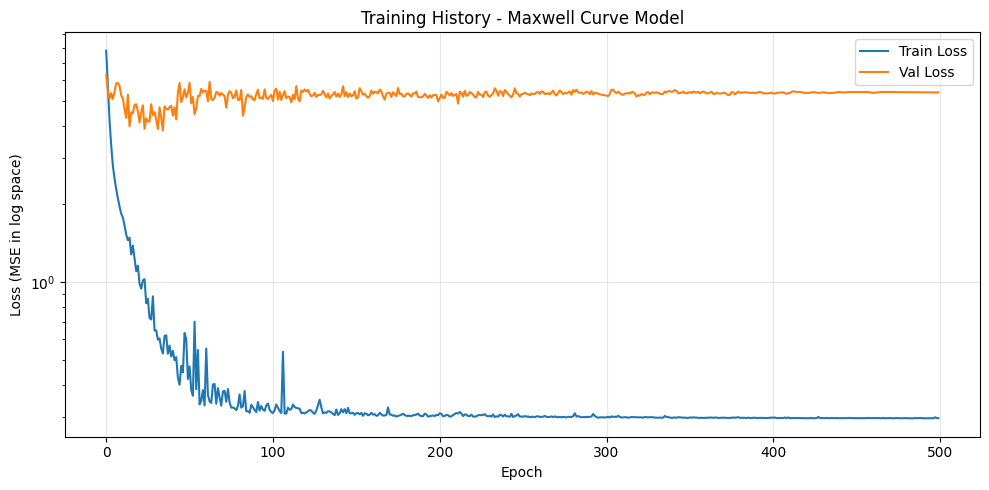

In [16]:
# ============================================================================
# 加载数据并训练模型
# ============================================================================

# 1. 创建曲线数据集
print("正在加载和处理数据...")
curve_dataset = RheologyCurveDataset("PB_Data.csv")

# 2. 创建模型
n_modes = 6  # 使用6个Maxwell模式
input_dim = len(curve_dataset.sample_feature_cols)
curve_model = MaxwellCurvePredictor(input_dim=input_dim, n_modes=n_modes, hidden_dim=128).to(device)

print(f"\n模型参数:")
print(f"  输入维度: {input_dim}")
print(f"  Maxwell模式数: {n_modes}")
print(f"  总参数量: {sum(p.numel() for p in curve_model.parameters()):,}")

# 3. 训练模型
train_losses_curve, val_losses_curve = train_curve_model(
    curve_model, 
    curve_dataset, 
    epochs=500, 
    lr=1e-3
)

测试曲线模型对几何参数的敏感性


/var/folders/74/b8381_dj5kz02s63kv277jqh0000gn/T/ipykernel_2040/1883153118.py:116: UserWarning: Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/74/b8381_dj5kz02s63kv277jqh0000gn/T/ipykernel_2040/1883153118.py:116: UserWarning: Glyph 31895 (\N{CJK UNIFIED IDEOGRAPH-7C97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/74/b8381_dj5kz02s63kv277jqh0000gn/T/ipykernel_2040/1883153118.py:116: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/74/b8381_dj5kz02s63kv277jqh0000gn/T/ipykernel_2040/1883153118.py:116: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/74/b8381_dj5kz02s63kv277jqh0000gn/T/ipykernel_2040/1883153118.py:116: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/74/b838

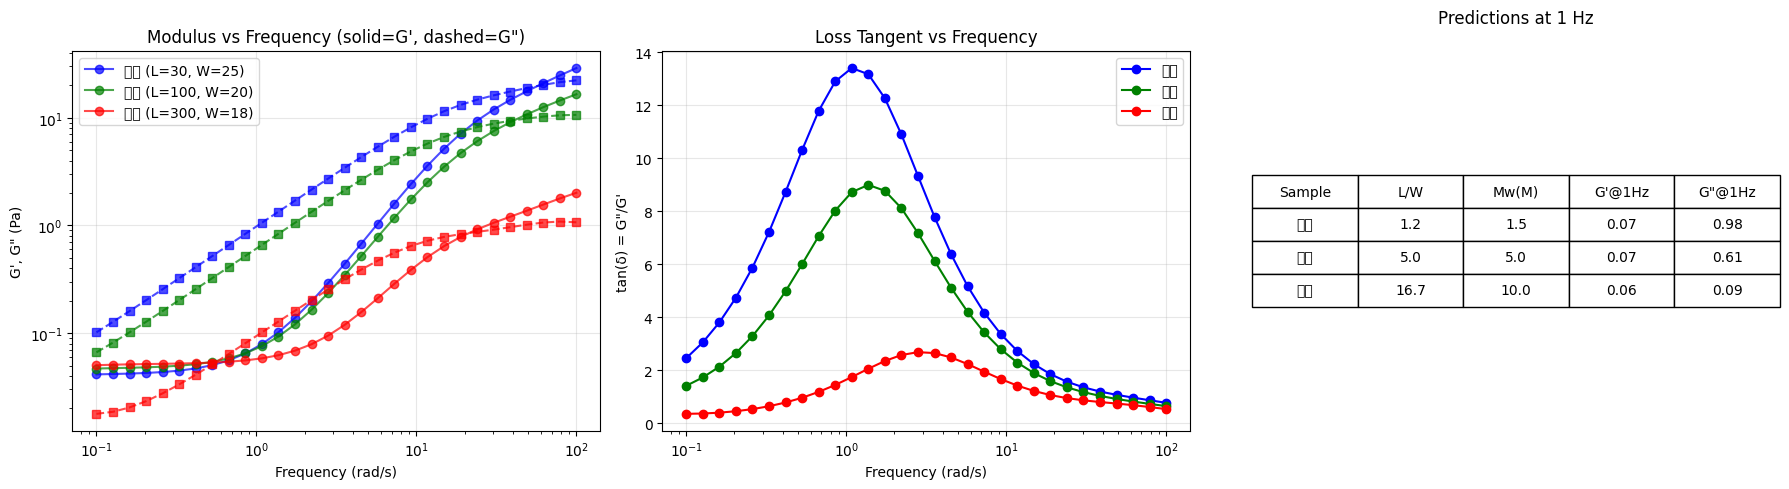


数值对比（1 Hz）:
name  Length  Width  AspectRatio  Mw_M  G_prime_1Hz  G_double_prime_1Hz
  短粗      30     25     1.200000   1.5     0.073943            0.979564
  中等     100     20     5.000000   5.0     0.071851            0.610462
  长细     300     18    16.666667  10.0     0.057438            0.094056


敏感性分析:
G' 变化范围: 1.29倍
G" 变化范围: 10.41倍
⚠️  模型对几何参数的敏感性仍然较低


In [17]:
# ============================================================================
# 模型评估：测试对几何参数的敏感性
# ============================================================================

def test_geometry_sensitivity(model, curve_dataset):
    """测试曲线模型对几何参数的敏感性"""
    
    print("=" * 80)
    print("测试曲线模型对几何参数的敏感性")
    print("=" * 80)
    
    # 定义测试频率范围
    test_frequencies = np.logspace(-1, 2, 30)  # 0.1 到 100 rad/s
    
    # 测试不同几何参数
    test_cases = [
        {"name": "短粗", "Length_nm": 30, "Width_nm": 25, "Mw": 1.5e6},
        {"name": "中等", "Length_nm": 100, "Width_nm": 20, "Mw": 5e6},
        {"name": "长细", "Length_nm": 300, "Width_nm": 18, "Mw": 10e6},
    ]
    
    model.eval()
    results = []
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['blue', 'green', 'red']
    
    with torch.no_grad():
        for i, case in enumerate(test_cases):
            # 构建样本特征
            Length_nm = case["Length_nm"]
            Width_nm = case["Width_nm"]
            Mw = case["Mw"]
            Mn = Mw * 0.99
            
            aspect_ratio = Length_nm / Width_nm
            T_ref, C1, C2 = 25, 8.86, 101.6
            Temp_C = 25
            c = 0.06
            
            aT = 10 ** (-C1 * (Temp_C - T_ref) / (C2 + Temp_C - T_ref))
            temp_inv = 1 / (Temp_C + 273.15)
            T_x_aspect = Temp_C * aspect_ratio
            
            sample_features = np.array([[
                Length_nm, Width_nm, aspect_ratio, Temp_C,
                temp_inv, T_x_aspect, aT,
                np.log10(Mw), np.log10(Mn), Mw/Mn, np.log10(c)
            ]])
            
            # 标准化
            features_scaled = curve_dataset.scaler_X.transform(sample_features)
            features_tensor = torch.FloatTensor(features_scaled).to(device)
            frequencies_tensor = torch.FloatTensor(test_frequencies).to(device)
            
            # 预测曲线
            G_prime, G_double_prime = model.predict_curve(features_tensor, frequencies_tensor)
            
            G_prime_np = G_prime.cpu().numpy().squeeze()
            G_double_prime_np = G_double_prime.cpu().numpy().squeeze()
            
            # 绘图
            axes[0].loglog(test_frequencies, G_prime_np, 'o-', 
                          label=f"{case['name']} (L={Length_nm}, W={Width_nm:.0f})",
                          color=colors[i], alpha=0.7)
            axes[0].loglog(test_frequencies, G_double_prime_np, 's--', 
                          color=colors[i], alpha=0.7)
            
            axes[1].semilogx(test_frequencies, G_double_prime_np / G_prime_np, 'o-',
                            label=case['name'], color=colors[i])
            
            # 保存结果
            results.append({
                'name': case['name'],
                'Length': Length_nm,
                'Width': Width_nm,
                'AspectRatio': aspect_ratio,
                'Mw_M': Mw/1e6,
                'G_prime_1Hz': np.interp(1.0, test_frequencies, G_prime_np),
                'G_double_prime_1Hz': np.interp(1.0, test_frequencies, G_double_prime_np)
            })
    
    # 设置图表
    axes[0].set_xlabel('Frequency (rad/s)')
    axes[0].set_ylabel('G\', G" (Pa)')
    axes[0].set_title('Modulus vs Frequency (solid=G\', dashed=G")')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Frequency (rad/s)')
    axes[1].set_ylabel('tan(δ) = G"/G\'')
    axes[1].set_title('Loss Tangent vs Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 对比表格
    results_df = pd.DataFrame(results)
    axes[2].axis('off')
    table_data = []
    table_data.append(['Sample', 'L/W', 'Mw(M)', 'G\'@1Hz', 'G"@1Hz'])
    for _, row in results_df.iterrows():
        table_data.append([
            row['name'],
            f"{row['AspectRatio']:.1f}",
            f"{row['Mw_M']:.1f}",
            f"{row['G_prime_1Hz']:.2f}",
            f"{row['G_double_prime_1Hz']:.2f}"
        ])
    
    table = axes[2].table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[2].set_title('Predictions at 1 Hz', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # 打印数值对比
    print("\n数值对比（1 Hz）:")
    print(results_df.to_string(index=False))
    
    # 计算变化幅度
    print("\n\n敏感性分析:")
    g1_range = results_df['G_prime_1Hz'].max() / results_df['G_prime_1Hz'].min()
    g2_range = results_df['G_double_prime_1Hz'].max() / results_df['G_double_prime_1Hz'].min()
    print(f"G' 变化范围: {g1_range:.2f}倍")
    print(f"G\" 变化范围: {g2_range:.2f}倍")
    
    if g1_range > 2:
        print("✅ 模型对几何参数有显著响应！")
    else:
        print("⚠️  模型对几何参数的敏感性仍然较低")
    
    return results_df

# 运行敏感性测试
sensitivity_results = test_geometry_sensitivity(curve_model, curve_dataset)